In [1]:
from __future__ import print_function
import time
import intrinio_sdk
from intrinio_sdk.rest import ApiException
from pprint import pprint
import datetime as dt
from datetime import date
from datetime import timedelta
import io
from collections import Counter
import numpy as np
from numpy import genfromtxt
import matplotlib.pyplot as plt
import pandas as pd

import requests, lxml
from lxml import html

In [2]:
from Platform import Stock, Portfolio

### TODO List ###

STOCK
1. Implement get_performance()
    - Add holidays to daterange_iter()
2. Find an API or some source of data
    - Maybe cache data in a folder as csv's
    - A Data
        - Allow Portfolio class to access data 
            - or maybe we need to design/think about how we want to be abstracting this data for strategies
        - How to store and how to access
        - Tenquant api key (Brian): YnJpYW44ODIybWlAZ21haWwuY29t
    
PORTFOLIO
1. Redo Portfolio
    - buy() method
    - performance needs to show individual stocks in portfolio
    - less priority: show performance together
2. Shorting

PLATFORM
1. Make Platform
    - Testing trade logic goes here
    - Abstract on Portfolio

Once everything gets a bit more flushed out, we can parallelize our work between these classes hopefully

## CHANGE LIST ##
##### -- Anything important that people should know got changed --

4/24/19: Changed how self.prices is stored

4/24/19: Now only using the datetime.date object to represent all dates

In [3]:
data = pd.read_csv("https://query1.finance.yahoo.com/v7/finance/download/AAPL?period1=1546502400&period2=1587279600&interval=1d&events=history")

In [29]:
from __future__ import print_function
import time
import intrinio_sdk
from intrinio_sdk.rest import ApiException
from pprint import pprint
import datetime as dt
from datetime import date
from datetime import timedelta
import io
from collections import Counter
import numpy as np
from numpy import genfromtxt
import matplotlib.pyplot as plt
import pandas as pd
import requests 

import requests, lxml
from lxml import html


class Stock:
    api_key = 'YnJpYW44ODIybWlAZ21haWwuY29t'
    url = 'https://api.tenquant.io/'
    def __init__(self, ticker, start_date=dt.datetime.today().date(), end_date=dt.datetime.today().date(), frequency='daily', page_size=100):
        self.ticker = ticker
        self.frequency = frequency
        self.start_date = self.parse_date(start_date)
        self.end_date = self.parse_date(end_date)
        self.data = self.get_clean_yahoo()
        self.date_range_iter = self.daterange(start_date, end_date)

        self.prices = dict(
                            zip(map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d').date(), self.data['Date']),
                                self.data['Adj Close'])
                        )
        self.start_price = self.prices[self.start_date]
#         self.end_price = self.prices[self.end_date]

    def parse_date(self, date):
        """ Parses string dates in format YYYY-MM-DD to datetime objects and adjusts them
        based on frequency. """

        """ TODO:
        - Account for holidays
        """
        if not isinstance(date, dt.date):
            date = dt.datetime.strptime(date, '%Y-%m-%d').date()

        if self.frequency == 'daily':
            day = date.weekday()
            if day >= 5:
                print('The day you chose is not a weekday.')
                date -= timedelta(days=day - day%4)

        elif self.frequency == 'weekly':
            day = date.weekday()
            if day > 0:
                print('Weeks start on a Monday')
                date -= timedelta(days=day)

        elif self.frequency == 'monthly':
            print('Month starts on the 1st')
            date = date.replace(day=1)
        return date

    def get_clean_yahoo(self):
        """ Creates the appropriate URL depending on ticker, frequency and dates """
        time_period = {'daily': '1d', 'weekly': '1wk', 'monthly': '1mo'}
        freq = time_period[self.frequency]
        start_date = int(time.mktime(self.start_date.timetuple()))
        end_date = int(time.mktime(self.end_date.timetuple()))
        yahoo_url = "https://query1.finance.yahoo.com/v7/finance/download/"+ self.ticker + "?period1=" + str(start_date) + "&period2=" + str(end_date) + "&interval=" + \
                    freq + "&events=history"
#         print(yahoo_url)
        data = pd.read_csv(yahoo_url)
        # sort in ascending date
        data = data.reindex(index=data.index[::-1])
        return data

    def display_close_price(self):
        #TODO: add start and end date arguments that maybe default to the start and end date
        #TODO: decide to standardize between either datetime64ns or datetime objects
            #chosen to have all dates in self.prices to be datetime objects
        #TODO: maybe we should make our own datetime actually
        plt.figure(figsize=(10,7))
        plt.title(self.ticker + " Stock Price")
        plt.plot(pd.to_datetime(self.data['Date']), list(self.prices.values()))
        plt.xlabel("Date")
        plt.ylabel("Price")
        plt.show()
        
    def get_10k_data(self, end_date):
        end_date_formatted = end_date.strftime('%Y%m%d')
        print(end_date_formatted)
        paramters = {'key': self.api_key, 'ticker': self.ticker, 'date': end_date_formatted}
        r = requests.get(url=self.url + '/historical?ticker=' + self.ticker + '&date=' + end_date_formatted + '&key=' + self.api_key)
        print(r)
        data = r.json()
        return data
        
    def get_performance(self, start=None, end=None):
        #TODO: Implementation depends on how we choose to represent datetime
        #TODO: Fix this thing, add holidays to daterange first
        if (start == None):
            start = self.start_date
        if (end == None):
            end = self.end_date

        max_ind = len(self.prices)
        curr_ind = 0
        gains = []
        for date in self.daterange(start, end):
            if ((date - self.start_date).total_seconds() < 0):
                gains.append(0)
            elif ((self.end_date - date).total_seconds() < 0):
                gains.append(0)
            elif (curr_ind >= max_ind):
                gains.append(0)
            else:
                gains.append(self.prices[date] - self.start_price)
                curr_ind += 1
        return np.array(gains)

    def daterange(self, start_date, end_date):
        #TODO: need to implement holidays, maybe even historical holidays, not really sure
        delta = timedelta(days=1)
        while start_date <= end_date:
            if (start_date.weekday() >= 5):
                start_date += delta
                continue
            yield start_date
            start_date += delta

    def get_df(self):
        return self.data

    def display_df(self, head=None):
        if head:
            display(self.data.head(head))
        else:
            display(self.data)

class Portfolio:
    def __init__(self, capital=1000):
        self.capital = float(capital)
        self.holdings = {}

    def buy(self, ticker='', start=date.today(), end=date.today()):
        newStock = Stock(ticker, start_date=start, end_date=end)
        self.holdings[newStock] = (start, end)

    def display_performance(self):
        min_date = min(self.holdings.values(), key = lambda x: x[0])[0]
        max_date = max(self.holdings.values(), key = lambda x: x[1])[1]

        perf = np.array([self.capital] * len(list(self.daterange(min_date, max_date))))
        for i in self.holdings:
            perf += i.get_performance(start=min_date, end=max_date)

        plt.title("Portfolio Performance")
        plt.plot(list(self.daterange(min_date, max_date)), perf)
        plt.xlabel("Date")
        plt.ylabel("$")
        plt.show()
        #some of the logic is wrong, so that if two stocks are seperated, then jumps to 1000 which is not right

    def daterange(self, start_date, end_date):
        delta = timedelta(days=1)
        while start_date <= end_date:
            if (start_date.weekday() >= 5):
                start_date += delta
                continue
            yield start_date
            start_date += delta


The day you chose is not a weekday.


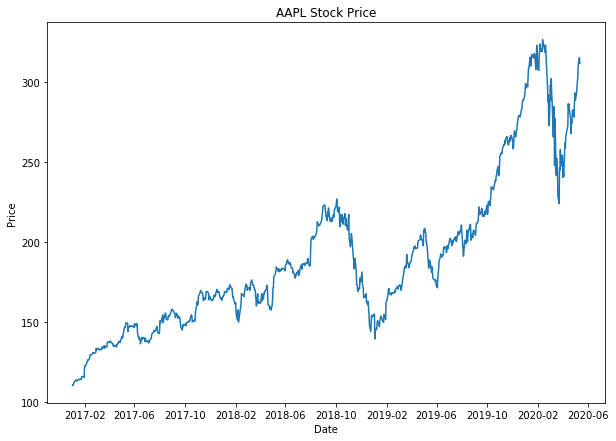

,Date,Open,High,Low,Close,Adj Close,Volume
844,2020-05-12,317.829987,319.690002,310.910004,311.410004,311.410004,40575300
843,2020-05-11,308.100006,317.049988,307.239990,315.010010,315.010010,36405900
842,2020-05-08,305.640015,310.350006,304.290009,310.130005,310.130005,33512000
841,2020-05-07,303.220001,305.170013,301.970001,303.739990,302.919983,28803800
840,2020-05-06,300.459991,303.239990,298.869995,300.630005,299.818390,35583400
839,2020-05-05,295.059998,301.000000,294.459991,297.559998,296.756683,36937800
838,2020-05-04,289.170013,293.690002,286.320007,293.160004,292.368561,33392000
837,2020-05-01,286.250000,299.000000,285.850006,289.070007,288.289612,60154200
836,2020-04-30,289.959991,294.529999,288.350006,293.799988,293.006836,45766000
835,2020-04-29,284.730011,289.670013,283.890015,287.730011,286.953247,34320200


20170103
https://api.tenquant.io/historical?ticker=AAPL&key=YnJpYW44ODIybWlAZ21haWwuY29t
<Response [200]>


In [36]:
appl2 = Stock(ticker="AAPL", start_date=date(2017, 1, 3), end_date=date.today())
appl2.display_close_price()
appl2.display_df(10)
response = appl2.get_10k_data(end_date=date(2017, 1, 3))

In [39]:
a = requests.get(url='https://www.capitaliq.com/CIQDotNet/Financial/excelReport.aspx?companyid=27444752&statekey=2288c3b2179c42edbaaf43a799f2da9b&worksheet=1&myContentType=3')

In [44]:
a.

'\r\n<!DOCTYPE html>\r\n<html>\r\n<head>\r\n\t<meta charset="utf-8">\r\n\t<meta http-equiv="X-UA-Compatible" content="IE=edge">\r\n\t<meta name="viewport" content="width=device-width, initial-scale=1.0">\r\n\t<link rel="shortcut icon" href="/favicon.ico" type="image/x-icon">\r\n\r\n\t<title>Log In | S&amp;P Capital IQ</title>\r\n\r\n\t<!-- Bootstrap core CSS -->\r\n\t<link href="/css/bootstrap.min.css" rel="stylesheet">\r\n\r\n\t<!-- Styles for RSS Modal Popup -->\r\n\t<link href="/css/select2.css" rel="stylesheet"/>\r\n\t<link href="/css/select2-bootstrap.css" rel="stylesheet" media="screen,print"/>\r\n\r\n\r\n\t<!-- Custom styles -->\r\n\t<link href="/css/spgmi-styles.css" rel="stylesheet">\r\n\r\n\t<!-- HTML5 shim and Respond.js IE8 support of HTML5 elements and media queries -->\r\n\t<!--[if lt IE 9]>\r\n\t\t<script src="/umbracoScripts/html5shiv.js"></script>\r\n\t\t<script src="/umbracoScripts/respond.min.js"></script>\r\n\t<![endif]-->\r\n\r\n\t<!--[if (gte IE 6)&(lte IE 8)]>\r\

In [37]:
response

{'assets': 321686000000.0,
 'bookvalue': 128249000000.0,
 'comprehensiveincome': 46666000000.0,
 'comprehensiveincomeattributabletononcontrollinginterest': 0.0,
 'comprehensiveincomeattributabletoparent': 46666000000.0,
 'costofrevenue': 131376000000.0,
 'country': 'United States',
 'currencycode': 'USD',
 'currentassets': 106869000000.0,
 'currentliabilities': 79006000000.0,
 'date': '2016-09-24',
 'dividendpayments': 11965000000.0,
 'dividendyield': 0.019304748664021768,
 'documenttype': '10-K',
 'duration': 4,
 'equity': 128249000000.0,
 'exchangegainslosses': 341000000.0,
 'extraordaryitemsgainloss': 0.0,
 'grossprofit': 84263000000.0,
 'incomebeforeequitymethodinvestments': 45687000000.0,
 'incomefromcontinuingoperationsaftertax': 45687000000.0,
 'incomefromcontinuingoperationsbeforetax': 61372000000.0,
 'incomefromequitymethodinvestments': 0.0,
 'incometaxexpensebenefit': 15685000000.0,
 'interestanddebtexpense': 1456000000.0,
 'liabilities': 193437000000.0,
 'liabilitiesandequit

In [32]:
pd.read_json(response)

ValueError: Invalid file path or buffer object type: <class 'dict'>

In [ ]:
testport = Portfolio()
testport.buy('AAPL', start=date(2020, 1, 3))
testport.buy('MSFT', start=date(2019, 4, 20))
testport.display_performance()

In [ ]:
# class Stock:
#     def __init__(self, ticker, start_date=date.today(), end_date=date.today(), frequency='daily', page_size=100):
#         intrinio_sdk.ApiClient().configuration.api_key['api_key'] = 'OmEzMWY4NDEzMzRlOGM3Y2ZjNmY3ZjAwZWRmZWI2MTIy'
        
#         self.ticker = ticker
#         self.start_date = start_date
#         self.end_date = end_date
#         self.frequency = frequency
#         self.security_api = intrinio_sdk.SecurityApi()
#         self.api_response = self.security_api.get_security_stock_prices(
#             ticker, start_date=start_date, end_date=end_date, 
#             frequency=frequency, page_size=int((end_date - start_date).days), next_page='')
#         self.date_range_iter = self.daterange(start_date, end_date)
#         self.prices = self.api_response.stock_prices_dict
#         self.start_price = self.api_response.stock_prices_dict[0]['adj_close']
#         self.end_price = self.api_response.stock_prices_dict[-1]['adj_close']
    
#     def display_close_price(self):
#         plt.title(self.ticker + " Stock Price")
#         close_prices = []
#         date = []
#         #### CHANGED ####
#         prices_df = pd.DataFrame(self.prices)
#         close_prices = prices_df['adj_close']
#         date = prices_df['date']
#         #### CHANGED ####
#         plt.plot(date, close_prices)
#         plt.xlabel("Date")
#         plt.ylabel("Price")
#         plt.show()
# #         #TODO: add start and end date arguments 
    
#     def get_stock_price_dict(self):
#         return self.api_response.stock_prices_dict
    
#     def get_api_response(self):
#         return self.api_response
    
# #     def start_price(self):
# #         return self.api_response.stock_prices_dict[0]['close']
    
# #     def end_price(self):
# #         return self.api_response.stock_prices_dict[-1]['close']
    
#     def get_performance(self, start=None, end=None):
#         if (start == None):
#             start = self.start_date
#         if (end == None):
#             end = self.end_date
        
#         max_ind = len(self.prices)
#         curr_ind = 0
#         gains = []

#         for date in self.daterange(start, end):
#             if ((date - self.start_date).total_seconds() < 0):
#                 gains.append(0)
#             elif ((self.end_date - date).total_seconds() < 0):
#                 gains.append(0)
#             elif (curr_ind >= max_ind):
#                 gains.append(0)
#             else:
#                 gains.append(self.prices[curr_ind]['adj_close'] - self.start_price)
#                 curr_ind += 1
#         return np.array(gains)
    
#     def daterange(self, start_date, end_date):
#         delta = timedelta(days=1)
#         while start_date <= end_date:
#             if (start_date.weekday() >= 5):
#                 start_date += delta
#                 continue
#             yield start_date
#             start_date += delta
    